<a href="https://colab.research.google.com/github/outinletter/DataAnalysis/blob/main/%ED%85%8C%EB%94%94%EB%85%B8%ED%8A%B8%2C_LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
!pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-10-08,72300,72400,71500,71500,14043287,-0.001397
2021-10-12,70700,70900,68700,69000,31001484,-0.034965
2021-10-13,68700,69600,68300,68800,24172015,-0.002899
2021-10-14,69000,69800,68800,69400,19520641,0.008721
2021-10-15,70200,71000,70000,70100,17531847,0.010086


**미국 주식 데이터**도 가져올 수 있습니다.

In [6]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [7]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-10-11,142.81,142.27,144.81,141.81,64260000.0,-0.0006
2021-10-12,141.51,143.23,143.25,141.04,73040000.0,-0.0091
2021-10-13,140.91,141.24,141.40,139.20,77570000.0,-0.0042
2021-10-14,143.76,142.11,143.88,141.51,67210000.0,0.0202
2021-10-15,144.84,143.77,144.90,143.51,67680000.0,0.0075


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [9]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [10]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [11]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [12]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [13]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니, 

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [14]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [15]:
stock = fdr.DataReader(STOCK_CODE)

In [16]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-09-22,1227,1242,1209,1212,59140,NaN
1997-09-23,1209,1215,1192,1192,66140,-0.016502
1997-09-24,1186,1213,1165,1194,93880,0.001678
1997-09-25,1193,1193,1170,1179,70400,-0.012563
1997-09-26,1170,1179,1161,1174,70500,-0.004241


In [17]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-10-08,72300,72400,71500,71500,14043287,-0.001397
2021-10-12,70700,70900,68700,69000,31001484,-0.034965
2021-10-13,68700,69600,68300,68800,24172015,-0.002899
2021-10-14,69000,69800,68800,69400,19520641,0.008721
2021-10-15,70200,71000,70000,70100,17531847,0.010086


In [18]:
stock.index

DatetimeIndex(['1997-09-22', '1997-09-23', '1997-09-24', '1997-09-25',
               '1997-09-26', '1997-09-27', '1997-09-29', '1997-09-30',
               '1997-10-01', '1997-10-02',
               ...
               '2021-09-30', '2021-10-01', '2021-10-05', '2021-10-06',
               '2021-10-07', '2021-10-08', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [19]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [20]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-09-22,1227,1242,1209,1212,59140,NaN,1997,9,22
1997-09-23,1209,1215,1192,1192,66140,-0.016502,1997,9,23
1997-09-24,1186,1213,1165,1194,93880,0.001678,1997,9,24
1997-09-25,1193,1193,1170,1179,70400,-0.012563,1997,9,25
1997-09-26,1170,1179,1161,1174,70500,-0.004241,1997,9,26


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


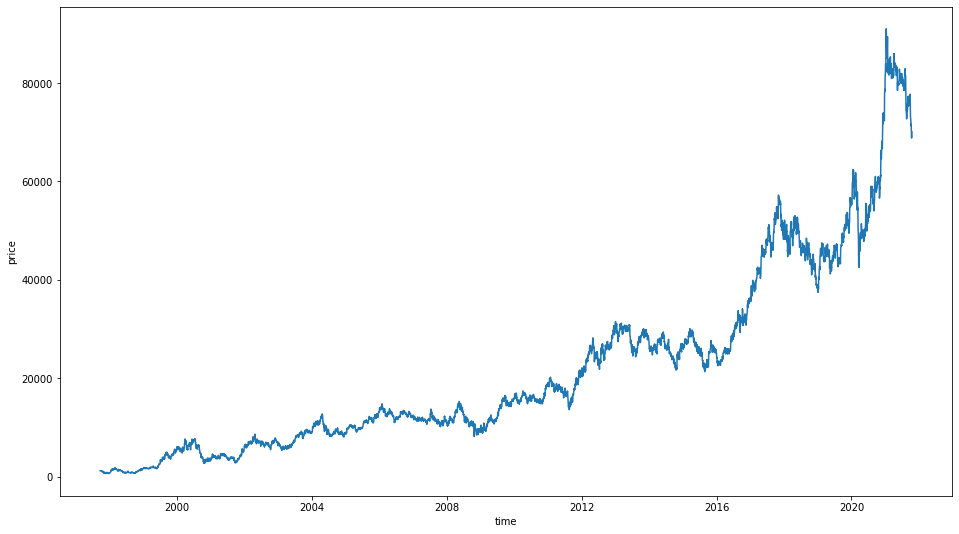

In [21]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


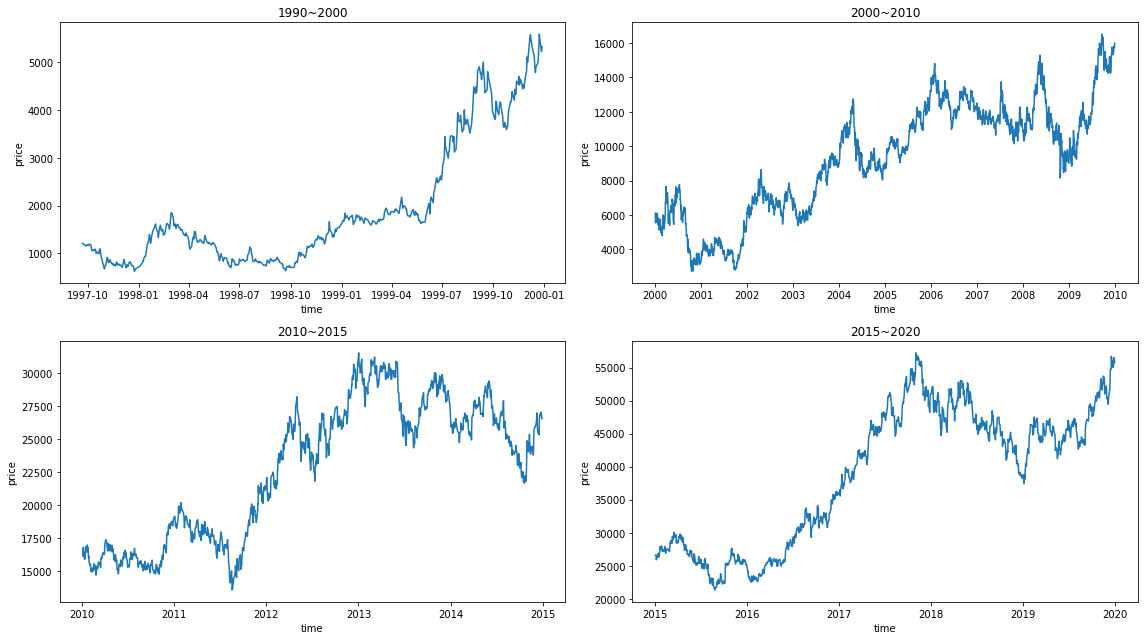

In [22]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[1.35880399e-02, 1.28305785e-02, 1.35083799e-02, 6.47317230e-03,
        6.54883220e-04],
       [1.33887043e-02, 1.25516529e-02, 1.33184358e-02, 6.25186726e-03,
        7.32397298e-04],
       [1.31339978e-02, 1.25309917e-02, 1.30167598e-02, 6.27399776e-03,
        1.03957451e-03],
       ...,
       [7.60797342e-01, 7.19008264e-01, 7.63128492e-01, 7.54351410e-01,
        2.67667349e-01],
       [7.64119601e-01, 7.21074380e-01, 7.68715084e-01, 7.60990561e-01,
        2.16160640e-01],
       [7.77408638e-01, 7.33471074e-01, 7.82122905e-01, 7.68736238e-01,
        1.94137850e-01]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [24]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [27]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [28]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [29]:
x_train

,Open,High,Low,Volume
0,0.013588,0.012831,0.013508,0.000655
1,0.013389,0.012552,0.013318,0.000732
2,0.013134,0.012531,0.013017,0.001040
3,0.013212,0.012324,0.013073,0.000780
4,0.012957,0.012180,0.012972,0.000781
...,...,...,...,...
4795,0.350377,0.328099,0.350838,0.002095
4796,0.346622,0.331808,0.349721,0.001812
4797,0.355925,0.339876,0.357542,0.002160
4798,0.367885,0.343182,0.363352,0.002806


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [30]:
import tensorflow as tf

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [32]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [33]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [34]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [36]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [37]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [38]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
150/150 [==============================] - 35s 19ms/step - loss: 1.8675e-04 - mse: 3.7350e-04 - val_loss: 0.0052 - val_mse: 0.0104

Epoch 00001: val_loss improved from inf to 0.00519, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
150/150 [==============================] - 2s 13ms/step - loss: 2.3644e-05 - mse: 4.7288e-05 - val_loss: 0.0044 - val_mse: 0.0088

Epoch 00002: val_loss improved from 0.00519 to 0.00442, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
150/150 [==============================] - 2s 13ms/step - loss: 2.2551e-05 - mse: 4.5102e-05 - val_loss: 0.0047 - val_mse: 0.0094

Epoch 00003: val_loss did not improve from 0.00442
Epoch 4/50
150/150 [==============================] - 2s 13ms/step - loss: 2.2697e-05 - mse: 4.5395e-05 - val_loss: 0.0046 - val_mse: 0.0091

Epoch 00004: val_loss did not improve from 0.00442
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 2.0559e-05 - mse: 4.1118e-05 - val_loss: 0.0050 - val_mse: 0.0099

Epo

저장한 ModelCheckpoint 를 로드합니다.

In [39]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [40]:
pred = model.predict(test_data)

In [41]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

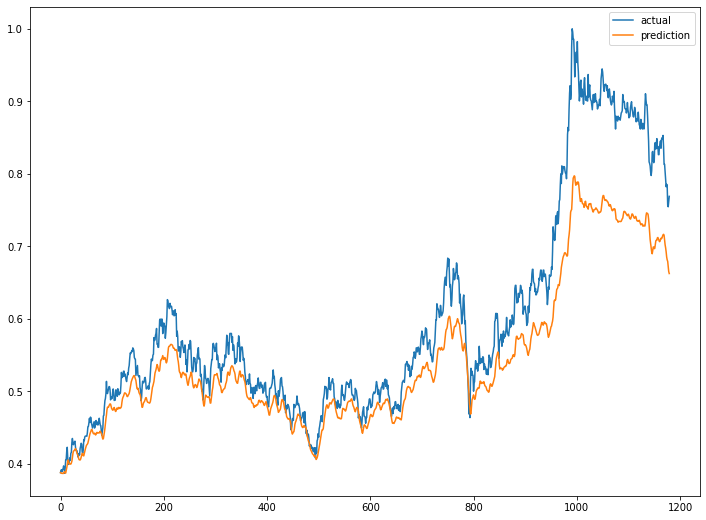

In [42]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()